In [1]:
# Update sklearn to prevent version mismatches
!pip install sklearn --upgrade

Requirement already up-to-date: sklearn in c:\users\ashka\anaconda3\lib\site-packages (0.0)


In [2]:
import pandas as pd

In [3]:
df = pd.read_csv("exoplanet_data.csv")
# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')
# Drop the null rows
df = df.dropna()
df.head()

,koi_disposition,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,CONFIRMED,0,0,0,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,...,-81,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,FALSE POSITIVE,0,1,0,0,19.899140,1.490000e-05,-1.490000e-05,175.850252,0.000581,...,-176,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
2,FALSE POSITIVE,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,...,-174,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
3,CONFIRMED,0,0,0,0,2.525592,3.760000e-06,-3.760000e-06,171.595550,0.001130,...,-211,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509
4,CONFIRMED,0,0,0,0,4.134435,1.050000e-05,-1.050000e-05,172.979370,0.001900,...,-232,4.486,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714


In [4]:
# Set features. This will also be used as your x values.
X = df[['koi_period', 'koi_teq', 'koi_insol', 'koi_model_snr', 'koi_duration', 'koi_impact', 'koi_depth', 'koi_prad']]
y = df['koi_disposition']
X.head()

,koi_period,koi_teq,koi_insol,koi_model_snr,koi_duration,koi_impact,koi_depth,koi_prad
0,54.418383,443,9.11,25.8,4.50700,0.586,874.8,2.83
1,19.899140,638,39.30,76.3,1.78220,0.969,10829.0,14.60
2,1.736952,1395,891.96,505.6,2.40641,1.276,8079.2,33.46
3,2.525592,1406,926.16,40.9,1.65450,0.701,603.3,2.75
4,4.134435,1160,427.65,40.2,3.14020,0.762,686.0,2.77


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [6]:
# Scale your data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
from sklearn.preprocessing import LabelEncoder

# Step 1: Label-encode data set
label_encoder_train = LabelEncoder().fit(y_train)
label_encoder_test = LabelEncoder().fit(y_test)
encoded_y_train = label_encoder_train.transform(y_train)
encoded_y_test = label_encoder_test.transform(y_test)

In [8]:
from tensorflow.keras.utils import to_categorical

# One-hot encoding
y_train_categorical = to_categorical(encoded_y_train)
y_test_categorical = to_categorical(encoded_y_test)
y_test_categorical

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)

## Using Neural Network Model

In [9]:
from tensorflow.keras.models import load_model
model = load_model("nasa.h5")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [10]:
model_loss, model_accuracy = model.evaluate(X_test_scaled, y_test_categorical, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

1748/1748 - 0s - loss: 0.6752 - acc: 0.7449
Loss: 0.6752293456337272, Accuracy: 0.7448512315750122


In [11]:
predictions = model.predict_classes(X_test_scaled)
predictions

array([0, 1, 1, ..., 2, 0, 1], dtype=int64)

In [12]:
predictions_label = label_encoder_test.inverse_transform(predictions)

In [13]:
gg = pd.DataFrame({"Predictions": predictions_label, "Actual":y_test})
gg.head()

,Predictions,Actual
4990,CANDIDATE,FALSE POSITIVE
1425,CONFIRMED,CONFIRMED
144,CONFIRMED,CONFIRMED
6589,FALSE POSITIVE,FALSE POSITIVE
4443,FALSE POSITIVE,CANDIDATE


In [14]:
# To confirm accuracy
s = gg["Predictions"].count()
wrong = 0
for i in range(0,s):
    a=gg["Predictions"].iloc[i]
    b=gg["Actual"].iloc[i]
    if a != b:
        wrong = wrong + 1
        
(s - wrong) / s

0.7448512585812357

In [15]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

conf = confusion_matrix(gg['Actual'], gg['Predictions'])

tn = conf[0][0]
fp = conf[0][1]
fn = conf[1][0]
tp = conf[1][1]

labels = 'True Negative', 'False Negative', 'False Positive', 'True Positive'
sizes = [tn,fp,fn,tp]
explode = (0, 0, 0, 0)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.show()

<Figure size 640x480 with 1 Axes>

In [16]:
target_names = ["False Positive", "Candidate", "Confirmed"]
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions_label,
                            target_names=target_names))

                precision    recall  f1-score   support

False Positive       0.57      0.56      0.57       420
     Candidate       0.72      0.79      0.75       461
     Confirmed       0.84      0.81      0.83       867

      accuracy                           0.74      1748
     macro avg       0.71      0.72      0.72      1748
  weighted avg       0.75      0.74      0.75      1748



## Using Random Forest Model

In [17]:
import pickle
pkl_filename = "tree.pkl"
with open(pkl_filename, 'rb') as file:
    rt = pickle.load(file)

In [18]:
predictions = rt.predict(X_test_scaled)

In [19]:
tt = pd.DataFrame({"Predictions": predictions, "Actual":y_test})
tt.head()

,Predictions,Actual
4990,FALSE POSITIVE,FALSE POSITIVE
1425,CONFIRMED,CONFIRMED
144,CONFIRMED,CONFIRMED
6589,FALSE POSITIVE,FALSE POSITIVE
4443,FALSE POSITIVE,CANDIDATE


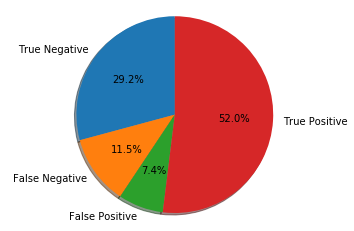

In [20]:
conf = confusion_matrix(tt['Actual'], tt['Predictions'])

tn = conf[0][0]
fp = conf[0][1]
fn = conf[1][0]
tp = conf[1][1]

labels = 'True Negative', 'False Negative', 'False Positive', 'True Positive'
sizes = [tn,fp,fn,tp]
explode = (0, 0, 0, 0)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.show()

In [21]:
target_names = ["False Positive", "Candidate", "Confirmed"]
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions,
                            target_names=target_names))

                precision    recall  f1-score   support

False Positive       0.63      0.50      0.56       420
     Candidate       0.74      0.81      0.77       461
     Confirmed       0.82      0.86      0.84       867

      accuracy                           0.76      1748
     macro avg       0.73      0.72      0.72      1748
  weighted avg       0.75      0.76      0.75      1748

